# Regression discontinuity: banking recovery

## Data Preprocessing

In [1]:
#Import Modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statsmodels.api as sm

In [2]:
#Read Dataset
df =pd.read_csv('/content/bank_data.csv')
thresholds = np.array([0,1000,2000,3000,5000])

#Converting Variable columns into Categorical variables
def convert_cat_cols(df,cat_var_limit=10,verbose=False):
  """
    Converts columns with a small amount of unique values that are of
    type Object into categorical variables
  """
  temp_var=df.apply(lambda x:len(x.value_counts())<cat_var_limit)
  temp_var2=df.apply(lambda x:x.value_counts().index.dtype=='O')
  df[temp_var[temp_var2].index]=df[temp_var[temp_var2].index].astype('category')

  return df

df=convert_cat_cols(df)
print('******Sample Data Info****** \n')
df.info()

******Sample Data Info****** 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1882 entries, 0 to 1881
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   id                        1882 non-null   int64   
 1   expected_recovery_amount  1882 non-null   int64   
 2   actual_recovery_amount    1882 non-null   float64 
 3   recovery_strategy         1882 non-null   category
 4   age                       1882 non-null   int64   
 5   sex                       1882 non-null   category
dtypes: category(2), float64(1), int64(3)
memory usage: 62.9 KB


In [3]:
print('******Sample Data Summary Statistics****** \n')
df.describe()

******Sample Data Summary Statistics****** 



,id,expected_recovery_amount,actual_recovery_amount,age
count,1882.000000,1882.000000,1882.000000,1882.000000
mean,1035.596174,2759.967588,4000.967837,39.650372
std,591.458429,2019.826565,4576.506350,15.453072
min,6.000000,194.000000,200.425000,18.000000
25%,534.250000,1261.250000,1045.190300,28.000000
50%,1029.500000,2062.000000,2115.446373,35.000000
75%,1551.750000,3569.500000,5417.237207,50.000000
max,2056.000000,9964.000000,34398.479710,84.000000


In [4]:
print('******Sample Data Head****** \n')
df.head()

******Sample Data Head****** 



,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


# Required Functions

In [20]:
thresholds = np.array([0,1000, 2000, 3000, 5000])
def draw_scatterplot_column(x_axis,name_x_axis,y_axis,name_y_axis,thresholds):
  sns.set(style="whitegrid")

  plt.subplots(figsize=(10, 10))
  plt.subplot(2, 1, 1)
  plt.scatter(x=x_axis, y=y_axis, c="b", label=name_y_axis, cmap='plasma', s=20, alpha=0.7)
  for threshold in thresholds:
      plt.axvline(x=threshold, color='black', linestyle='-', label=f'{name_x_axis} = {threshold}')
  plt.colorbar(label=name_y_axis)
  plt.xlabel(name_x_axis)
  plt.ylabel(name_y_axis)
  plt.legend(loc=2)

  plt.subplot(2, 1, 2)
  plt.scatter(x=x_axis, y=y_axis, cmap='plasma', s=20, alpha=0.7)
  plt.xlim(0, 2000)
  #plt.ylim(y_axis.min(), 60)
  plt.axvline(x=1000, color='black', linestyle='-', label=f'{name_x_axis} = 1000' )
  plt.colorbar(label=name_y_axis)
  plt.xlabel('Expected Recovery Amount')
  plt.ylabel(name_y_axis)
  plt.title(f'Zoomed-in Scatter Plot: {name_y_axis} vs. {name_x_axis}')
  plt.legend(loc=2)

  # Adjust layout and display the plot
  plt.tight_layout()
  plt.show()


In [6]:
df=df.set_index(['recovery_strategy','id']).sort_index()
recovery_strategy_labels=df.index.get_level_values(0).categories
def calculate_statistical_test(df,name_x_axis,name_y_axis,diff_up,diff_down,x_lim=0):
  diff_up=2
  diff_down=100
  ctr=1
  for i in range(len(recovery_strategy_labels)-1):
    temp_low_var=df.loc[recovery_strategy_labels[i]].sort_values(name_x_axis,ascending=False)
    y_axis_column_low=temp_low_var[name_y_axis][diff_up:diff_down].values
    temp_high_var=df.loc[recovery_strategy_labels[i+1]].sort_values(name_x_axis,ascending=True)
    y_axis_column_high=temp_high_var[name_y_axis][diff_up:diff_down].values
    ######## Plotting ########
    plt.subplots(figsize=(10,10))
    plt.subplot(len(recovery_strategy_labels)-1,2,ctr)
    if(x_lim==1):
      plt.xlim(950, 1050)
      plt.scatter(x=temp_low_var[name_x_axis][diff_up:diff_down],\
                y=y_axis_column_low,c="b",s=4,label=str(f'{name_y_axis}: '+recovery_strategy_labels[i]))
      plt.scatter(x=temp_high_var[name_x_axis][diff_up:diff_down],\
                  y=y_axis_column_high,c="r",s=4,label=str(f'{name_y_axis}: '+recovery_strategy_labels[i+1]))
      plt.xlabel(name_x_axis)
      plt.ylabel(name_y_axis)
      plt.legend(loc=2)
      plt.title(f'{name_y_axis} Statistics : '+str(stats.kruskal(y_axis_column_low,y_axis_column_high)))
      break;
    else:
      plt.scatter(x=temp_low_var[name_x_axis][diff_up:diff_down],\
                y=y_axis_column_low,c="b",s=4,label=str(f'{name_y_axis}: '+recovery_strategy_labels[i]))
      plt.scatter(x=temp_high_var[name_x_axis][diff_up:diff_down],\
                  y=y_axis_column_high,c="r",s=4,label=str(f'{name_y_axis}: '+recovery_strategy_labels[i+1]))
      plt.xlabel(name_x_axis)
      plt.ylabel(name_y_axis)
      plt.legend(loc=2)
      plt.title(f'{name_y_axis} Statistics : '+str(stats.kruskal(y_axis_column_low,y_axis_column_high)))








In [7]:
def calculate_statistical_test_sex_column(df,name_x_axis,name_y_axis,diff_up,diff_down):
  for i in range(len(recovery_strategy_labels)-1):
    temp_low_var=df.loc[recovery_strategy_labels[i]].sort_values(name_x_axis,ascending=False)
    temp_high_var=df.loc[recovery_strategy_labels[i+1]].sort_values(name_x_axis,ascending=True)
    print('\n Upper bound '+recovery_strategy_labels[i]+' mean')
    temp_tab_var_low = temp_low_var[diff_up:diff_down].groupby('sex')
    print(temp_tab_var_low.mean())
    print('\n Lower bound '+recovery_strategy_labels[i+1]+' mean')
    temp_tab_var_high = temp_high_var[diff_up:diff_down].groupby('sex')
    print(temp_tab_var_high.mean())

    crosstab = pd.concat([temp_tab_var_low.count()['age'],\
                          temp_tab_var_high.count()['age']],axis='columns')
    chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
    print('\nChi square P-value of sex groups: '+ str(p_val))

#Graphical exploratory data analysis for age column

<ipython-input-5-4a310216a4ed>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)
<ipython-input-5-4a310216a4ed>:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x=x_axis, y=y_axis, c="b", label=name_y_axis, cmap='plasma', s=20, alpha=0.7)
<ipython-input-5-4a310216a4ed>:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x=x_axis, y=y_axis, cmap='plasma', s=20, alpha=0.7)


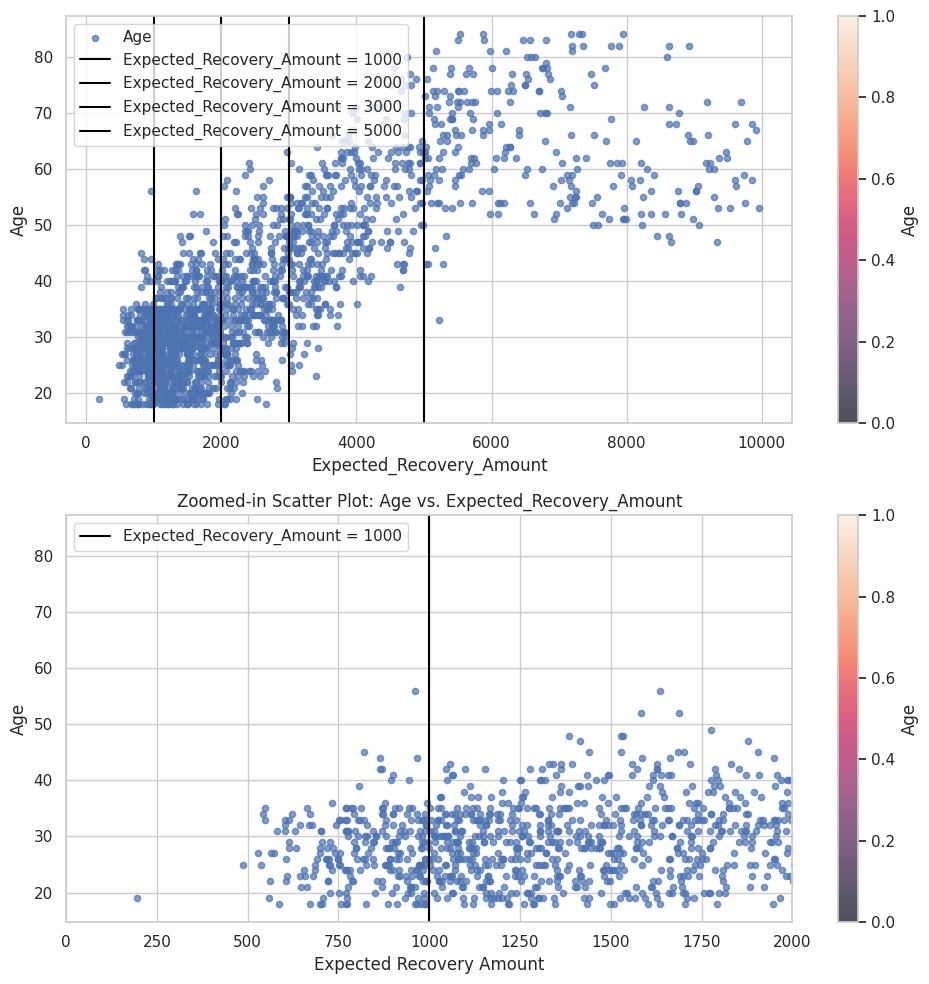

In [8]:
draw_scatterplot_column(df['expected_recovery_amount'],'Expected_Recovery_Amount',df['age'],'Age',thresholds)

 **Explain Result**
After making a scatter plot of the age as a function of Expected Recovery Amount we notice that there is no discontinuity with Age column

# Statistical test for age and sex columns

### Statistical test: age vs. expected recovery amount

<ipython-input-6-1523872371a9>:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(recovery_strategy_labels)-1,2,ctr)


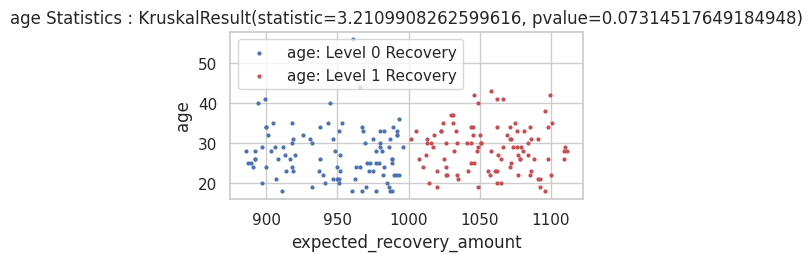

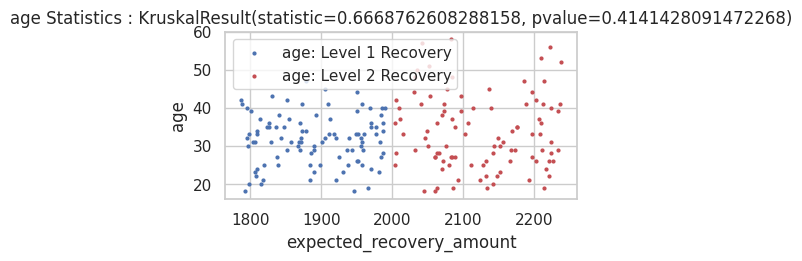

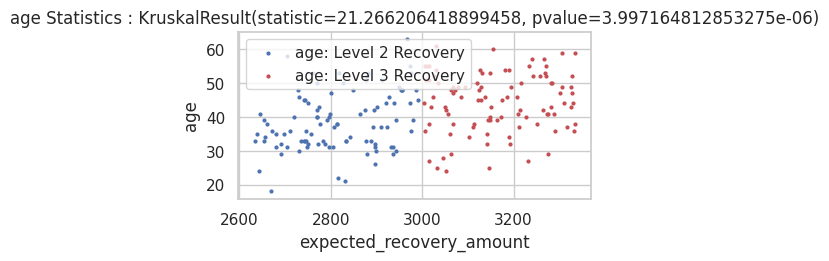

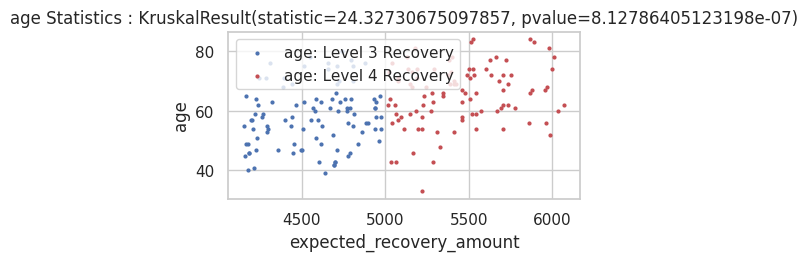

In [9]:
calculate_statistical_test(df,'expected_recovery_amount','age',2,100)

### Statistical test: sex vs. expected recovery amount

<ipython-input-6-1523872371a9>:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(recovery_strategy_labels)-1,2,ctr)


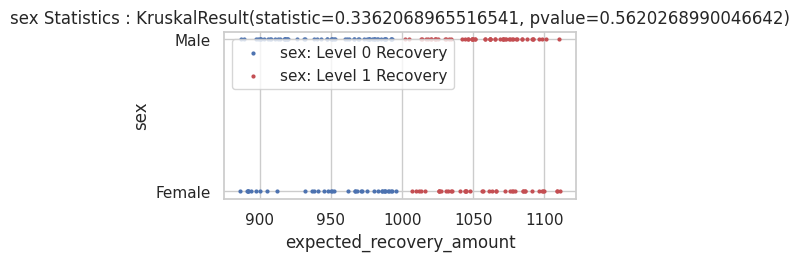

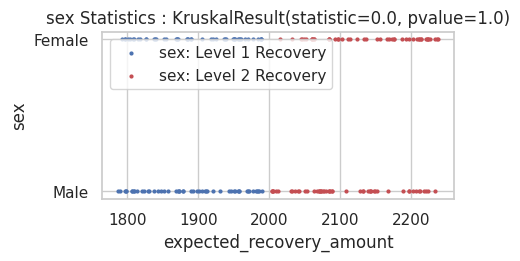

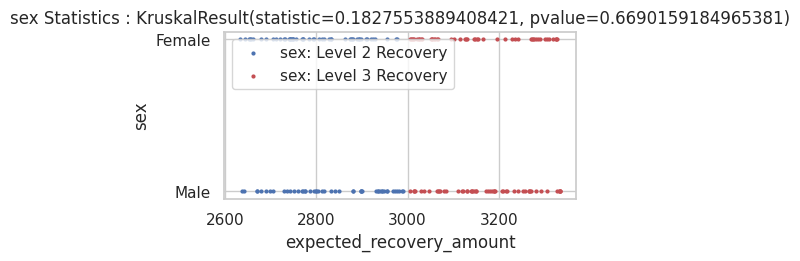

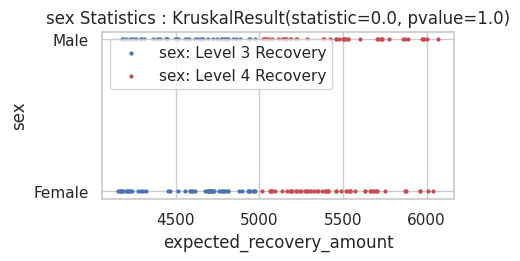

In [10]:
df_male = df.loc[df['sex'] == 'Male']
calculate_statistical_test(df,'expected_recovery_amount','sex',2,100)

In [11]:
calculate_statistical_test_sex_column(df,'expected_recovery_amount','sex',2,100)


 Upper bound Level 0 Recovery mean
        expected_recovery_amount  actual_recovery_amount        age
sex                                                                
Female                949.921053              627.543158  26.973684
Male                  945.966667              596.979333  27.600000

 Lower bound Level 1 Recovery mean
        expected_recovery_amount  actual_recovery_amount        age
sex                                                                
Female               1058.761905              972.609504  27.595238
Male                 1055.946429              930.630985  29.500000

Chi square P-value of sex groups: 0.6628448779596516

 Upper bound Level 1 Recovery mean
        expected_recovery_amount  actual_recovery_amount        age
sex                                                                
Female               1893.851064             1585.726972  30.021277
Male                 1889.156863             1806.032324  33.117647

 Lower bound Level 2 

# Graphical exploratory data analysis for actual recovery amount

<ipython-input-5-4a310216a4ed>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)
<ipython-input-5-4a310216a4ed>:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x=x_axis, y=y_axis, c="b", label=name_y_axis, cmap='plasma', s=20, alpha=0.7)
<ipython-input-5-4a310216a4ed>:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x=x_axis, y=y_axis, cmap='plasma', s=20, alpha=0.7)


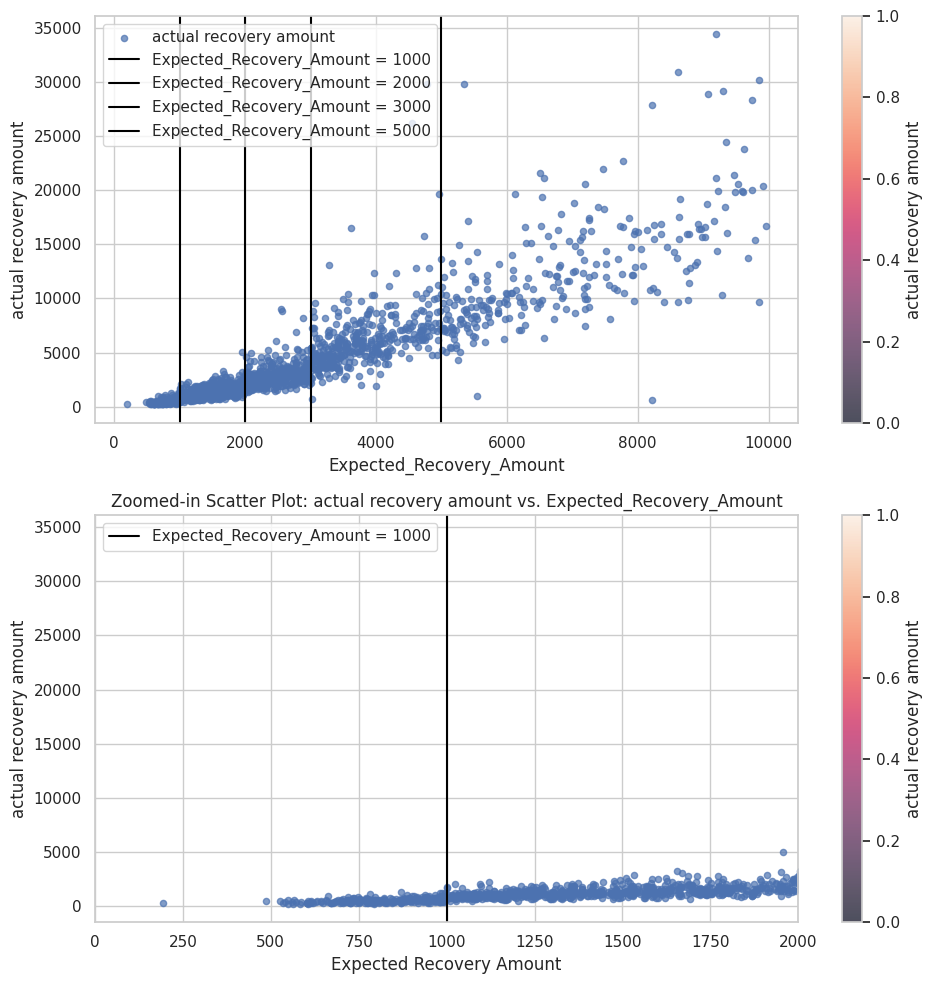

In [12]:
draw_scatterplot_column(df['expected_recovery_amount'],'Expected_Recovery_Amount',df['actual_recovery_amount'],'actual recovery amount',thresholds)

#Statistical test: actual recovery amount vs. expected recovery amount

<ipython-input-6-1523872371a9>:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(recovery_strategy_labels)-1,2,ctr)


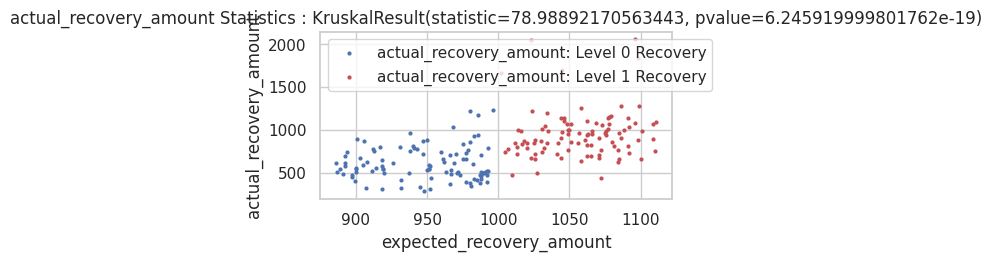

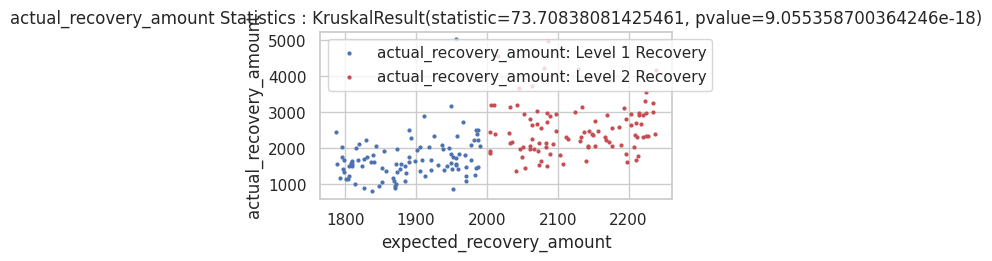

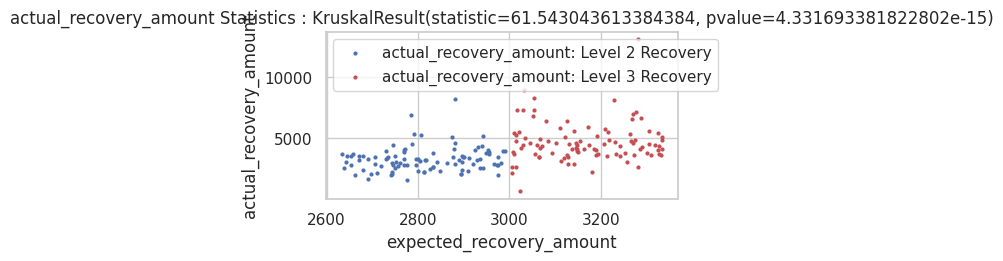

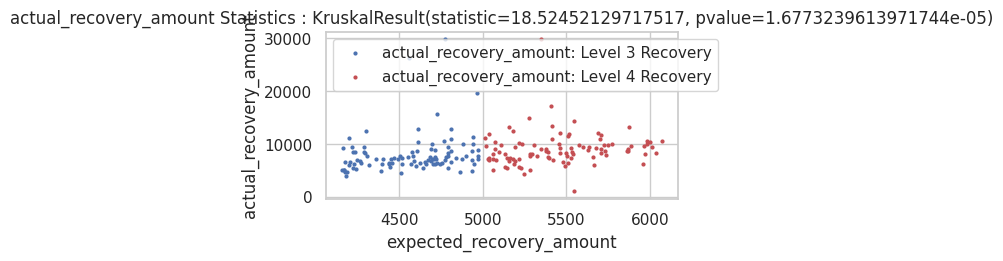

In [13]:
calculate_statistical_test(df,'expected_recovery_amount','actual_recovery_amount',2,100)

<ipython-input-6-1523872371a9>:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(len(recovery_strategy_labels)-1,2,ctr)


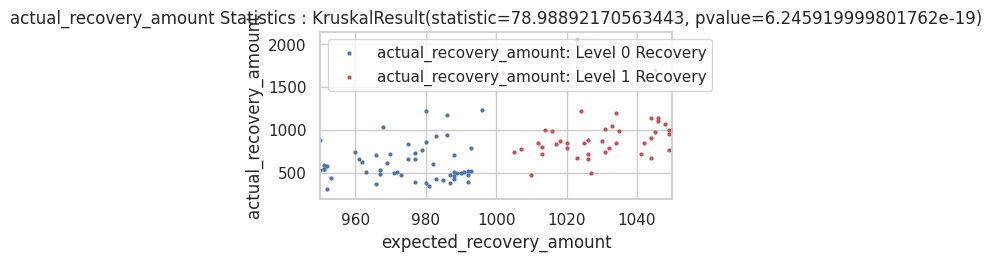

In [14]:
calculate_statistical_test(df,'expected_recovery_amount','actual_recovery_amount',2,100,True)

In [15]:
# This snippet can easily be written as part of the previous for loop
# It is written separately only for readability

diff_loop = 4
diff_start = 50
diff_end = 3
temp_var_1 = np.linspace(diff_end,diff_start,diff_loop)

win_range_tot = 100
win_loops = 5
temp_var_2=np.linspace(0,win_range_tot*2,win_loops+2)
temp_var_2[-1]=temp_var_2[-1]-1

for i in range(len(recovery_strategy_labels)-1):
    temp_low_var = df.loc[recovery_strategy_labels[i]].sort_values('expected_recovery_amount', ascending=False)
    temp_high_var = df.loc[recovery_strategy_labels[i+1]].sort_values('expected_recovery_amount', ascending=True)
    for j in range(diff_loop):
        diff_var_loop = int(temp_var_1[j])
        print('\n\nEffort: %s, Left/Right Statistics: %s'%(recovery_strategy_labels[i],\
              stats.kruskal(temp_low_var['actual_recovery_amount'][:diff_var_loop],\
                            temp_high_var['actual_recovery_amount'][:diff_var_loop])))
        print('Expected recovery amount bounds: %s and %s'%\
              (temp_low_var['expected_recovery_amount'].iloc[diff_var_loop],\
               temp_high_var['expected_recovery_amount'].iloc[diff_var_loop]))

    temp_win_var = pd.concat([temp_low_var[:win_range_tot],\
                             temp_high_var[:win_range_tot]]).\
    sort_values('expected_recovery_amount', ascending=False)

    for j in range(win_loops):
        diff_var_loop_l = int(temp_var_2[j])
        diff_var_loop_m = int(temp_var_2[j+1])
        diff_var_loop_u = int(temp_var_2[j+2])
        print('\n\nMoving window statistics: %s'%\
              str(stats.kruskal(temp_win_var['actual_recovery_amount'][diff_var_loop_l:diff_var_loop_m],\
                            temp_win_var['actual_recovery_amount'][diff_var_loop_m:diff_var_loop_u])))
        print(diff_var_loop_u,len(temp_win_var))
        print('Expected recovery amount bounds: %s and %s'%\
              (temp_win_var['expected_recovery_amount'].iloc[diff_var_loop_m],\
               temp_win_var['expected_recovery_amount'].iloc[diff_var_loop_u]))






Effort: Level 0 Recovery, Left/Right Statistics: KruskalResult(statistic=0.42857142857142705, pvalue=0.5126907602619241)
Expected recovery amount bounds: 993 and 1005


Effort: Level 0 Recovery, Left/Right Statistics: KruskalResult(statistic=9.613613613613595, pvalue=0.001931402150523139)
Expected recovery amount bounds: 986 and 1025


Effort: Level 0 Recovery, Left/Right Statistics: KruskalResult(statistic=14.179178576801576, pvalue=0.00016619948754682318)
Expected recovery amount bounds: 972 and 1044


Effort: Level 0 Recovery, Left/Right Statistics: KruskalResult(statistic=32.26816633663361, pvalue=1.3429560202513984e-08)
Expected recovery amount bounds: 951 and 1058


Moving window statistics: KruskalResult(statistic=1.7279305949591048, pvalue=0.18867539558740026)
66 200
Expected recovery amount bounds: 1072 and 1044


Moving window statistics: KruskalResult(statistic=1.1097829506134076, pvalue=0.2921291351146075)
100 200
Expected recovery amount bounds: 1044 and 1000


Moving wi

# Regression modeling: no threshold

In [16]:
diff_var=100

for i in range(len(recovery_strategy_labels)-1):
  temp_low_var=df.loc[recovery_strategy_labels[i],['expected_recovery_amount','actual_recovery_amount']].reset_index()\
  .sort_values('expected_recovery_amount',ascending=False)[:diff_var]
  temp_high_var=df.loc[recovery_strategy_labels[i+1],['expected_recovery_amount','actual_recovery_amount']].reset_index()\
  .sort_values('expected_recovery_amount',ascending=True)[:diff_var]
  temp_df = pd.concat([temp_low_var,temp_high_var])
  #define v and y
  X=temp_df['expected_recovery_amount']
  y=temp_df['actual_recovery_amount']
  X=sm.add_constant(X)
  model=sm.OLS(y,X).fit()
  predictions=model.predict(X)
  print('***********************************************************************************')
  print('\n\nOLS Summary for %s-%s'%(recovery_strategy_labels[i],recovery_strategy_labels[i+1]))
  print('\n')
  print(model.summary())


***********************************************************************************


OLS Summary for Level 0 Recovery-Level 1 Recovery


                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.276
Model:                                OLS   Adj. R-squared:                  0.272
Method:                     Least Squares   F-statistic:                     75.29
Date:                    Wed, 23 Aug 2023   Prob (F-statistic):           1.48e-15
Time:                            06:56:14   Log-Likelihood:                -1392.2
No. Observations:                     200   AIC:                             2788.
Df Residuals:                         198   BIC:                             2795.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                               c

**Explain Result** All regression coefficients show statistically significant coefficients.

# Regression modeling: adding true threshold

In [23]:
# This snippet can easily be written as part of the previous for loop
# It is written separately only for readability
# Import statsmodels
import statsmodels.api as sm

diff_var = 100

for i in range(len(recovery_strategy_labels)-1):
    temp_low_var = df.loc[recovery_strategy_labels[i],['expected_recovery_amount','actual_recovery_amount']].reset_index()\
    .sort_values('expected_recovery_amount', ascending=False)[:diff_var]
    temp_high_var = df.loc[recovery_strategy_labels[i+1],['expected_recovery_amount','actual_recovery_amount']].reset_index()\
    .sort_values('expected_recovery_amount', ascending=True)[:diff_var]
    temp_df = pd.concat([temp_low_var,temp_high_var])
    # Define X and y
    X = temp_df['expected_recovery_amount']
    y = temp_df['actual_recovery_amount']
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    print('\n\nOLS Summary for %s-%s'%(recovery_strategy_labels[i],recovery_strategy_labels[i+1]))
    print(model.summary())






OLS Summary for Level 0 Recovery-Level 1 Recovery
                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.276
Model:                                OLS   Adj. R-squared:                  0.272
Method:                     Least Squares   F-statistic:                     75.29
Date:                    Wed, 23 Aug 2023   Prob (F-statistic):           1.48e-15
Time:                            07:34:48   Log-Likelihood:                -1392.2
No. Observations:                     200   AIC:                             2788.
Df Residuals:                         198   BIC:                             2795.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

# Regression modeling: adjusting the window

In [21]:
# This snippet can easily be written as part of the previous for loop
# It is written separately only for readability

diff_var = 100
diff_var_end = 10
diff_loops = 3
temp_var = np.linspace(diff_var_end,diff_var,diff_loops).astype(int)

for i in range(len(recovery_strategy_labels)-1):
    for j in temp_var:
        temp_low_var = df.loc[recovery_strategy_labels[i],['expected_recovery_amount','actual_recovery_amount']].reset_index()\
        .sort_values('expected_recovery_amount', ascending=False)[:j]
        temp_high_var = df.loc[recovery_strategy_labels[i+1],['expected_recovery_amount','actual_recovery_amount']].reset_index()\
        .sort_values('expected_recovery_amount', ascending=True)[:j]
        temp_df = pd.concat([temp_low_var,temp_high_var])
        temp_df['indicator'] = np.where(temp_df['expected_recovery_amount']>thresholds[i+1],1,0)
        # Define X and y
        X = temp_df[['expected_recovery_amount','indicator']]
        y = temp_df['actual_recovery_amount']
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        predictions = model.predict(X)
        print('\n\nOLS Summary for %s-%s'%(recovery_strategy_labels[i],recovery_strategy_labels[i+1]))
        print('Expected recovery amount bounds: %s and %s'%\
              (temp_low_var['expected_recovery_amount'].iloc[j-1],\
               temp_high_var['expected_recovery_amount'].iloc[j-1]))
        print(model.summary())



OLS Summary for Level 0 Recovery-Level 1 Recovery
Expected recovery amount bounds: 990 and 1014
                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.128
Model:                                OLS   Adj. R-squared:                  0.025
Method:                     Least Squares   F-statistic:                     1.244
Date:                    Wed, 23 Aug 2023   Prob (F-statistic):              0.313
Time:                            07:00:38   Log-Likelihood:                -145.08
No. Observations:                      20   AIC:                             296.2
Df Residuals:                          17   BIC:                             299.2
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|    